<a href="https://colab.research.google.com/github/blurred421/LFD473-code/blob/main/labs/jb_Lab%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Instructions

In the lab, you're presented a task such as building a dataset, training a model, or writing a training loop, and we'll provide the code structured in such a way that you can fill in the blanks in the code using the knowledge you acquired in the chapters that precede the lab. You should be able to find appropriate snippets of code in the course content that work well in the lab with minor or no adjustments.

The blanks in the code are indicated by ellipsis (`...`) and comments (`# write your code here`).

In some cases, we'll provide you partial code to ensure the right variables are populated and any code that follows it runs accordingly.

```python
# write your code here
x = ...
```

The solution should be a single statement that replaces the ellipsis, such as:

```python
# write your code here
x = [0, 1, 2]
```

In some other cases, when there is no new variable being created, the blanks are shown like in the example below:

```python
# write your code here
...
```

Although we're showing you only a single ellipsis (`...`), you may have to write more than one line of code to complete the step, such as:

```python
# write your code here
for i, xi in enumerate(x):
    x[i] = xi * 2
```

## Installation Notes

To run this notebook on Google Colab, you will need to install the following library: datasets.

In Google Colab, you can run the following command to install this library:

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.3 MB/s eta 0:00:00


## 5.4 Lab 2: Price Prediction

In this lab, we'll keep using the [100,000 UK Used Car Dataset](https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes) from Kaggle. It contains scraped data of used car listings split into CSV files according to the manufacturer: Audi, BMW, Ford, Hyundai, Mercedes, Skoda, Toyota, Vauxhall, and VW. It also contains a few extra files of particular models (`cclass.csv`, `focus.csv`, `unclean_cclass.csv`, and `unclean_focus.csv`) that we won't be using.

Each file has nine columns with the car's attributes: model, year, price, transmission, mileage, fuel type, road tax, fuel consumption (mpg), and engine size. Transmission, fuel type, and year are discrete/categorical attributes, the others are continous. Our goal here is to predict the car's price based on its other attributes.

To download the dataset, you'll need to create a Kaggle account. In the following sections, we're assuming the dataset was downloaded and unzipped to a local folder named `car_prices`. Alternatively, you can download it from the following link:

```
https://github.com/dvgodoy/assets/raw/main/PyTorchInPractice/data/100KUsedCar/car_prices.zip
```

In Colab, you can run the following commands to download and unzip the dataset:

In [2]:
!wget https://github.com/dvgodoy/assets/raw/main/PyTorchInPractice/data/100KUsedCar/car_prices.zip
!unzip car_prices.zip -d car_prices

--2025-03-11 12:43:48--  https://github.com/dvgodoy/assets/raw/main/PyTorchInPractice/data/100KUsedCar/car_prices.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/data/100KUsedCar/car_prices.zip [following]
--2025-03-11 12:43:48--  https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/data/100KUsedCar/car_prices.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1152744 (1.1M) [application/zip]
Saving to: ‘car_prices.zip’

car_prices.zip      100%[===================>]   1.10M  --.-KB/s    in 0.06s   

2025-03-11 12:43:49 (18.0 MB/s) - 

### 5.4.1 Recap

Let's recap what we did in Chapter 5 to load our data into a Hugging Face `Dataset`, so we can use it to train a new model in PyTorch. You may run all the cells in this section as they are.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

First, we built the "dropdown" dictionaries that we used to preprocess the data:

In [3]:
import os
import numpy as np
from torch.utils.data import DataLoader
from datasets import load_dataset, Split, DatasetDict

def filter_for_data(filename):
    return ("unclean" not in filename) and ("focus" not in filename) and ("cclass" not in filename) and filename.endswith(".csv")

def gen_encoder_dict(dataset, col):
    values = sorted(dataset.unique(col))
    values += ['UNKNOWN']
    return dict(zip(values, range(len(values))))

colnames = ['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'road_tax', 'mpg', 'engine_size']#, 'manufacturer']

folder = './car_prices'
data_files = sorted([os.path.join(folder, fname) for fname in os.listdir(folder) if filter_for_data(fname)])

dataset = load_dataset("csv", data_files=data_files,
                       sep=',',
                       skiprows=1,
                       column_names=colnames,
                       split=Split.ALL)

train_test = dataset.train_test_split(train_size=0.8) # split 0.8 | 0.2
val_test = train_test['test'].train_test_split(train_size=0.5) #split test/validation portion into .10|.10 ?

datasets = DatasetDict({'train': train_test['train'],
                       'val': val_test['train'],  # How is this defined through the split function?
                       'test': val_test['test']})

cont_attr = ['year', 'mileage', 'road_tax', 'mpg', 'engine_size']
cat_attr = ['model', 'transmission', 'fuel_type']

dropdown_encoders = {col: gen_encoder_dict(datasets['train'], col) for col in cat_attr}

Generating train split: 0 examples [00:00, ? examples/s]

Flattening the indices:   0%|          | 0/79349 [00:00<?, ? examples/s]

Next, we used the preprocessing function to assemble the required columns in our dataset:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

In [4]:
def preproc(row):
    colnames = ['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'road_tax', 'mpg', 'engine_size']#, 'manufacturer']

    cat_attr = ['model', 'transmission', 'fuel_type']
    cont_attr = ['year', 'mileage', 'road_tax', 'mpg', 'engine_size']
    target = 'price'

    cont_X = [float(row[name]) for name in cont_attr]
    cat_X = [dropdown_encoders[name].get(row[name], dropdown_encoders[name]['UNKNOWN']) for name in cat_attr]

    return {'label': np.array([float(row[target])], dtype=np.float32),
            'cont_X': np.array(cont_X, dtype=np.float32),
            'cat_X': np.array(cat_X, dtype=int)}

In [5]:
datasets = datasets.map(preproc)
datasets = datasets.select_columns(['label', 'cont_X', 'cat_X'])
datasets = datasets.with_format('torch')

Map:   0%|          | 0/79349 [00:00<?, ? examples/s]

Map:   0%|          | 0/9919 [00:00<?, ? examples/s]

Map:   0%|          | 0/9919 [00:00<?, ? examples/s]

Once the datasets are ready, we created data loaders so we can load mini-batches of data, one at a time:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [6]:
dataloaders = {}
dataloaders['train'] = DataLoader(dataset=datasets['train'], batch_size=128, drop_last=True, shuffle=True)
dataloaders['val'] = DataLoader(dataset=datasets['val'], batch_size=128)
dataloaders['test'] = DataLoader(dataset=datasets['test'], batch_size=128)

### 5.4.3 Custom Model

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

You know the drill: write a custom model class that implements both `__init__()` and `forward()` methods. You can use the model you wrote in Lab 1 as a starting point.

In the constructor method, you will define the parts that make up your model, like linear layers and embeddings, as class attributes. Don't forget to include a call to `super().__init__()` at the top of the method so it executes the code from the parent class before your own. In our case, the model will receive the following arguments:

- `n_cont`: the number of continuous attributes
- `cat_list`: a list of lists of unique values of categorical attributes (the values from the dropdown encoders)
- `emb_dim`: the number of dimensions of each embedding (we're keeping them the same for every categorical attribute for simplicity)

The `forward()` method is where the magic happens, as you know. It receives an input `x`, which can be anything (e.g. a tensor, a tuple, a dictionary), and forwards this input through your model's components, such as layers, activation functions, and embeddings. In the end, it should return a prediction.

Don't forget your data loader is returning dictionaries now, you'll need to make adjustments to how your model treats its inputs. Also, don't forget to add a batch normalization layer to preprocess the continuous attributes and, optionally, you can also add batch normalization layers after each hidden linear layer. Please refer to the diagram below for the implementation.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch3/lab2_model.png)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FFN(nn.Module):
    def __init__(self, n_cont, cat_list, emb_dim):
        super().__init__()

        # Embedding layers
        embedding_layers = []
        # Creates one embedding layer for each categorical feature

        # write your code here
        for categories in cat_list:
            embedding_layers.append(nn.Embedding(len(categories), emb_dim))

        self.emb_layers = nn.ModuleList(embedding_layers)

        # Total number of embedding dimensions
        self.n_emb = len(cat_list) * emb_dim
        self.n_cont = n_cont
        # Batch Normalization layer for continuous features
        self.bn_input = nn.BatchNorm1d(n_cont)

        # Linear Layer(s)
        lin_layers = []
        # The input layers takes as many inputs as the number of continuous features
        # plus the total number of concatenated embeddings
        # The number of outputs is your own choice
        # Optionally, add more hidden layers, don't forget to match the dimensions if you do
        # write your code here
        lin_layers.append(nn.Linear(self.n_emb + self.n_cont, 100))
        self.lin_layers = nn.ModuleList(lin_layers)

        # Batch Normalization Layer(s)
        bn_layers = []
        # Creates batch normalization layers for each linear hidden layer

        # write your code here
        bn_layers.append(nn.BatchNorm1d(100))
        self.bn_layers = nn.ModuleList(bn_layers)

        # The output layer must have as many inputs as there were outputs in the last hidden layer
        # write your code here
        self.output_layer = nn.Linear(self.lin_layers[-1].out_features, 1)

        # Layer initialization
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data, nonlinearity='relu')
        nn.init.kaiming_normal_(self.output_layer.weight.data, nonlinearity='relu')

    def forward(self, inputs):
        # The inputs are the features as returned in the first element of a tuple
        # coming from the dataset/dataloader
        # Make sure you split it into continuous and categorical attributes according
        # to your dataset implementation of __getitem__
        # write your code here
        cont_data, cat_data = inputs['cont_X'], inputs['cat_X']

        # Retrieve embeddings for each categorical attribute and concatenate them
        embeddings = []
        # write your code here
        for i, layer in enumerate(self.emb_layers):
            embeddings.append(layer(cat_data[:, i]))
        embeddings = torch.cat(embeddings, 1)

        # Normalizes continuous features using Batch Normalization layer
        normalized_cont_data = self.bn_input(cont_data)

        # Concatenate all features together, normalized continuous and embeddings
        # write your code here
        x = torch.cat([normalized_cont_data, embeddings], 1)

        # Run the inputs through each layer and applies an activation function and batch norm to each output
        for layer, bn_layer in zip(self.lin_layers, self.bn_layers):
            # write your code here
            x = layer(x)
            x = F.relu(x)
            x = bn_layer(x)

        # Run the output of the last linear layer through the output layer
        # write your code here
        x = self.output_layer(x)

        # Return the prediction
        # write your code here
        return x

### 5.4.4 Training

Now it is time to write your own training loop once again. First, you need to instantiate your model.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

Just run the cell below as is to populate a few variables and visualize the outputs:

In [8]:
n_cont = len(cont_attr)
cat_list = [np.array(list(dropdown_encoders[name].values())) for name in cat_attr]  #why are they called dropdown encoders?

n_cont, cat_list

(5,
 [array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 171, 172, 173, 

The `n_cont` variable contains the number of continuous attributes you're using. The `cat_list` variable contains a list of lists, each inner list containing the unique values corresponding to one of the categorical attributes ("dropdowns").

Both variables, together with the number of embedding dimensions you chose (`emb_dim`), should be used as arguments to create an instance of your custom model class (`FFN`):

In [9]:
torch.manual_seed(42)

# write your code here
emb_dim = 5
model = FFN(n_cont, cat_list, emb_dim=emb_dim)

Now, create the appropriate loss function for the task:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step2.png)

In [10]:
# write your code here
loss_fn = nn.MSELoss()

Then, create an optimizer that will update your model's parameters:

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step3.png)

In [11]:
# Suggested learning rate
lr = 3e-3

# write your code here
optimizer = optim.Adam(model.parameters(), lr=lr)

Next, you will write the training loop using the data loaders to iterate through your training and validation data (these loops are written for you already).

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step4.png)

The training loop itself is pretty much the same as in the previous lab, but don't forget your data loaders return dictionaries now, so you'll need to adjust they way your data is being sent to the appropriate device.

In [12]:
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epochs = 20

losses = torch.empty(n_epochs)
val_losses = torch.empty(n_epochs)

best_loss = torch.inf
best_epoch = -1
patience = 3       # This is the amount of times we tolerate going through epochs before aborting.

model.to(device)

progress_bar = tqdm(range(n_epochs))

for epoch in progress_bar:
    batch_losses = []

    ## Training
    for i, batch in enumerate(dataloaders['train']):
        # Set the model to training mode
        # write your code here
        model.train()

        # Send batch features and targets to the device
        # write your code here
        batch['cont_X'] = batch['cont_X'].to(device)
        batch['cat_X'] = batch['cat_X'].to(device)
        batch['label'] = batch['label'].to(device)

        # Step 1 - forward pass
        # write your code here
        predictions = model(batch)

        # Step 2 - computing the loss
        # write your code here
        loss = loss_fn(predictions, batch['label'])

        # Step 3 - computing the gradients
        # Tip: it requires a single method call to backpropagate gradients
        # write your code here
        loss.backward()

        batch_losses.append(loss.item())

        # Step 4 - updating parameters and zeroing gradients
        # Tip: it takes two calls to optimizer's methods
        # write your code here
        optimizer.step()
        optimizer.zero_grad()

    losses[epoch] = torch.tensor(batch_losses).mean()

    ## Validation
    with torch.inference_mode():
        batch_losses = []

        for i, val_batch in enumerate(dataloaders['val']):
            # Set the model to evaluation mode
            # write your code here
            model.eval()

            # Send batch features and targets to the device
            # write your code here
            val_batch['cont_X'] = val_batch['cont_X'].to(device)
            val_batch['cat_X'] = val_batch['cat_X'].to(device)
            val_batch['label'] = val_batch['label'].to(device)

            # Step 1 - forward pass
            # write your code here
            predictions = model(val_batch)

            # Step 2 - computing the loss
            # write your code here
            loss = loss_fn(predictions, val_batch['label'])

            batch_losses.append(loss.item())

        val_losses[epoch] = torch.tensor(batch_losses).mean()

        if val_losses[epoch] < best_loss:
            best_loss = val_losses[epoch]
            best_epoch = epoch
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()},
                       'best_model.pth')
        elif (epoch - best_epoch) > patience:
            print(f"Early stopping at epoch #{epoch}")
            break

 50%|█████     | 10/20 [01:18<01:18,  7.81s/it]

Early stopping at epoch #10


Let's check the evolution of the losses. Run the cell below as is to plot your losses:

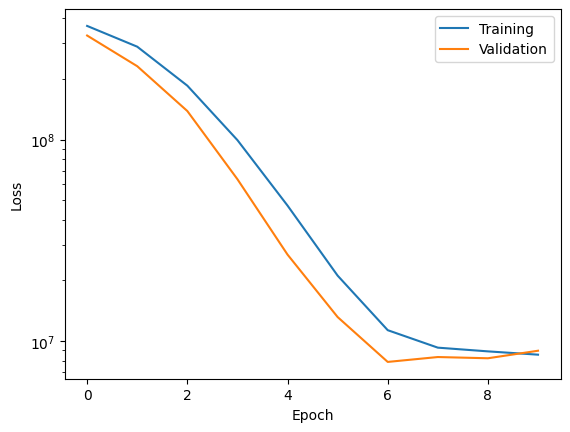

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses[:epoch], label='Training')
plt.plot(val_losses[:epoch], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

Then, let's compare predicted and actual values in the validation set.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

Run the cell below as is to visualize a scatterplot comparing predicted and actual values of fuel consumption. A perfect prediction corresponds to the dashed diagonal line.

Text(0.5, 1.0, 'Price')

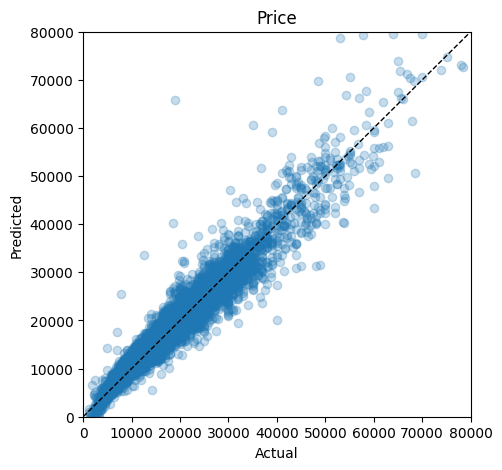

In [14]:
split = 'val'
y_hat = []
y_true = []
for batch in dataloaders[split]:
    model.eval()
    batch['cont_X'] = batch['cont_X'].to(device)
    batch['cat_X'] = batch['cat_X'].to(device)
    batch['label'] = batch['label'].to(device)
    y_hat.extend(model(batch).tolist())
    y_true.extend(batch['label'].tolist())

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(y_true, y_hat, alpha=0.25)
ax.plot([0, 80000], [0, 80000], linestyle='--', c='k', linewidth=1)
ax.set_xlabel('Actual')
ax.set_xlim([0, 80000])
ax.set_ylabel('Predicted')
ax.set_ylim([0, 80000])
ax.set_title('Price')

Ideally, you'll see a cloud of points around the diagonal line. What about the R2 score?

In [15]:
from sklearn.metrics import r2_score
r2_score(y_true, y_hat)

0.8571439938334179

If your cloud of points were indeed around the diagonal line, you're probably expecting a high R2 score (>0.8). If you got a surprisingly low value for it, can you guess why?

TIP: Try removing the `set_ylim()` range and look for extreme or negative values. If, for some reason, your model is producing extreme predictions (even if there's only a few of them), it may impact negatively the R2 score.